# Home 3: Build a CNN for image recognition.

### Name: Erika Deckter


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accurcy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    
4. Upload this .HTML file to your Github repo.

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2019F/blob/master/homework/HM3/HM3.html


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

Using TensorFlow backend.


170500096/170498071 [==============================] - 11s 0us/step
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
    #Define number of rows in y
    rows = y.shape[0]
    #Define vector of all zeroes with dimension number of examples in y x number of classes
    one_hot = numpy.zeros((rows, num_class))
    #Update each row with a 1 for the column that corresponds to the label
    for row in range(rows):
        label = y[row]
        one_hot[row,label] = 1
    
    return one_hot

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [3]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

Original Image


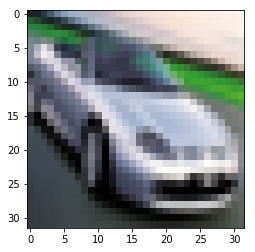

Random Augmentation of Image


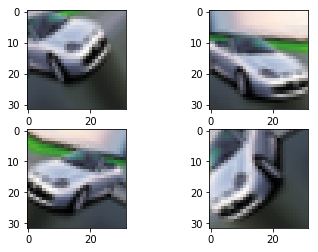

In [4]:
#This code performs data augmentation on the training images
from keras.preprocessing.image import ImageDataGenerator

#Create data generator function for training data that performs data augmentation
training_datagen = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True)
#Training data generator for batches of 100 images from the training dataset
training_generator = training_datagen.flow(x_tr, y_tr, batch_size=50)

#Create data generator function for validation data (don't augment the validation data)
validation_datagen = ImageDataGenerator()
#Validation data generator for a single batch of all the validation data
validation_generator = validation_datagen.flow(x_val, y_val, batch_size=50)

#Show sample augmented training image
from keras.preprocessing import image
import matplotlib.pyplot as plt

#Select image to display
example = x_tr[1000]
#Show original image
print('Original Image')
plt.imshow(image.array_to_img(example))
plt.show()

#Show grid of four random augmentations of image
i = 1
test_image = example.reshape((1,) + example.shape)
fig = plt.figure()
for sample in training_datagen.flow(test_image, batch_size=1):
    fig.add_subplot(2,2,i)
    plt.imshow(image.array_to_img(sample[0]))
    i += 1
    if i % 5 == 0:
        break
print('Random Augmentation of Image')
plt.show()

In [5]:
#Build CNN using Keras
#Model based on the Inception module architecture
#as described in the paper "Going deeper with convolutions"
#https://arxiv.org/pdf/1409.4842.pdf

import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from tensorflow.keras import optimizers

#Define shape of input
image_shape = x_tr.shape[1:]
input_shape = layers.Input(shape = image_shape)

def inception_module(dimensions, module_input):
  x1 = layers.Conv2D(dimensions, (1,1), padding='same')(module_input)
  x1 = layers.BatchNormalization()(x1)
  x1 = layers.Activation('relu')(x1)
  x1 = layers.Conv2D(dimensions, (5,5), padding='same')(x1)
  x1 = layers.BatchNormalization()(x1)
  x1 = layers.Activation('relu')(x1)
  
  x2 = layers.Conv2D(dimensions, (1,1), padding='same')(module_input)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.Activation('relu')(x2)
  x2 = layers.Conv2D(dimensions, (3,3), padding='same')(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.Activation('relu')(x2)
  
  x3 = layers.MaxPooling2D(3,3)(input_shape)
  x3 = layers.Conv2D(dimensions, (1,1), padding='same')(module_input)
  x3 = layers.BatchNormalization()(x3)
  x3 = layers.Activation('relu')(x3)
  
  x4 = layers.Conv2D(dimensions, (1,1), padding='same')(module_input)
  x4 = layers.BatchNormalization()(x4)
  x4 = layers.Activation('relu')(x4)
  
  module_output = layers.concatenate([x1, x2, x3, x4], axis=-1)
  
  return module_output

def build_model():
  conv_base = inception_module(64, input_shape)
  conv_base = inception_module(64, conv_base)
  conv_base = inception_module(64, conv_base)
  conv_base = inception_module(64, conv_base)
  conv_base = inception_module(64, conv_base)
  conv_base = layers.MaxPooling2D(3,3)(conv_base)
  conv_base = inception_module(128, conv_base)
  conv_base = inception_module(128, conv_base)
  conv_base = inception_module(128, conv_base)
  conv_base = inception_module(128, conv_base)
  conv_base = layers.AveragePooling2D(3,3)(conv_base)

  #Add dense layers
  output = layers.Flatten()(conv_base)
  output = layers.Dropout(0.4)(output)
  output = layers.Dense(4096)(output)
  output = layers.BatchNormalization()(output)
  output = layers.Activation('relu')(output)
  output = layers.Dropout(0.4)(output)
  output = layers.Dense(10)(output)
  output = layers.BatchNormalization()(output)
  output = layers.Activation('softmax')(output)

  model = models.Model(inputs = input_shape, outputs = output)
  
  return model

#Show model architecture summary
build_model().summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
_____________

Learning Rate: 0.000100
Epoch 1/20
800/800 [==============================] - 434s 543ms/step - loss: 1.6887 - acc: 0.3920 - val_loss: 1.4916 - val_acc: 0.4751
Epoch 2/20
800/800 [==============================] - 409s 512ms/step - loss: 1.4440 - acc: 0.5023 - val_loss: 1.3172 - val_acc: 0.5438
Epoch 3/20
800/800 [==============================] - 409s 511ms/step - loss: 1.3188 - acc: 0.5554 - val_loss: 1.2411 - val_acc: 0.5760
Epoch 4/20
800/800 [==============================] - 408s 510ms/step - loss: 1.2203 - acc: 0.5956 - val_loss: 1.0402 - val_acc: 0.6650
Epoch 5/20
800/800 [==============================] - 408s 510ms/step - loss: 1.1368 - acc: 0.6307 - val_loss: 0.9332 - val_acc: 0.6902
Epoch 6/20
800/800 [==============================] - 407s 509ms/step - loss: 1.0735 - acc: 0.6545 - val_loss: 1.0425 - val_acc: 0.6459
Epoch 7/20
800/800 [==============================] - 408s 511ms/step - loss: 1.0068 - acc: 0.6762 - val_loss: 0.8336 - val_acc: 0.7418
Epoch 8/20
800/800 [====

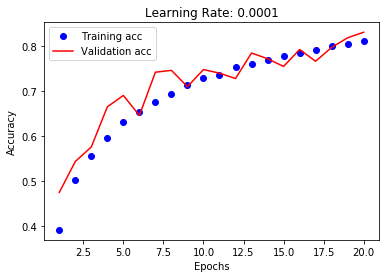

Learning Rate: 0.001000
Epoch 1/20
800/800 [==============================] - 432s 540ms/step - loss: 1.6469 - acc: 0.4114 - val_loss: 2.3570 - val_acc: 0.3542
Epoch 2/20
800/800 [==============================] - 410s 513ms/step - loss: 1.2764 - acc: 0.5602 - val_loss: 1.0580 - val_acc: 0.6368
Epoch 3/20
800/800 [==============================] - 410s 512ms/step - loss: 1.0867 - acc: 0.6303 - val_loss: 1.1410 - val_acc: 0.6285
Epoch 4/20
800/800 [==============================] - 410s 513ms/step - loss: 0.9723 - acc: 0.6696 - val_loss: 1.0754 - val_acc: 0.6429
Epoch 5/20
800/800 [==============================] - 411s 513ms/step - loss: 0.8858 - acc: 0.7017 - val_loss: 1.0112 - val_acc: 0.6687
Epoch 6/20
800/800 [==============================] - 411s 513ms/step - loss: 0.8224 - acc: 0.7250 - val_loss: 0.7487 - val_acc: 0.7511
Epoch 7/20
800/800 [==============================] - 410s 513ms/step - loss: 0.7597 - acc: 0.7434 - val_loss: 0.8670 - val_acc: 0.7201
Epoch 8/20
800/800 [====

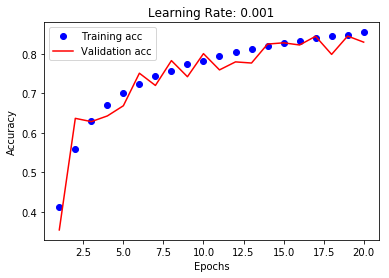

Learning Rate: 0.010000
Epoch 1/20
800/800 [==============================] - 439s 549ms/step - loss: 1.8073 - acc: 0.3314 - val_loss: 2.5365 - val_acc: 0.3340
Epoch 2/20
800/800 [==============================] - 412s 516ms/step - loss: 1.4590 - acc: 0.4724 - val_loss: 1.6582 - val_acc: 0.4745
Epoch 3/20
800/800 [==============================] - 410s 513ms/step - loss: 1.2900 - acc: 0.5360 - val_loss: 1.9999 - val_acc: 0.4625
Epoch 4/20
800/800 [==============================] - 412s 515ms/step - loss: 1.1727 - acc: 0.5834 - val_loss: 1.4409 - val_acc: 0.5460
Epoch 5/20
800/800 [==============================] - 410s 513ms/step - loss: 1.0962 - acc: 0.6122 - val_loss: 1.2536 - val_acc: 0.5939
Epoch 6/20
800/800 [==============================] - 411s 514ms/step - loss: 1.0350 - acc: 0.6362 - val_loss: 1.0889 - val_acc: 0.6325
Epoch 7/20
800/800 [==============================] - 410s 512ms/step - loss: 0.9796 - acc: 0.6562 - val_loss: 0.8298 - val_acc: 0.7105
Epoch 8/20
800/800 [====

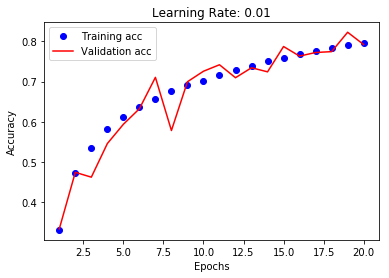

Learning Rate: 0.100000
Epoch 1/20
800/800 [==============================] - 438s 548ms/step - loss: 1.8740 - acc: 0.3025 - val_loss: 3.6661 - val_acc: 0.2545
Epoch 2/20
800/800 [==============================] - 408s 510ms/step - loss: 1.5348 - acc: 0.4394 - val_loss: 3.9163 - val_acc: 0.2639
Epoch 3/20
800/800 [==============================] - 407s 508ms/step - loss: 1.3873 - acc: 0.4990 - val_loss: 1.5446 - val_acc: 0.4998
Epoch 4/20
800/800 [==============================] - 407s 508ms/step - loss: 1.2882 - acc: 0.5410 - val_loss: 4.9677 - val_acc: 0.2678
Epoch 5/20
800/800 [==============================] - 406s 508ms/step - loss: 1.2064 - acc: 0.5737 - val_loss: 2.3846 - val_acc: 0.4453
Epoch 6/20
800/800 [==============================] - 408s 510ms/step - loss: 1.1480 - acc: 0.5940 - val_loss: 2.7647 - val_acc: 0.4000
Epoch 7/20
800/800 [==============================] - 406s 507ms/step - loss: 1.1012 - acc: 0.6133 - val_loss: 1.0250 - val_acc: 0.6515
Epoch 8/20
800/800 [====

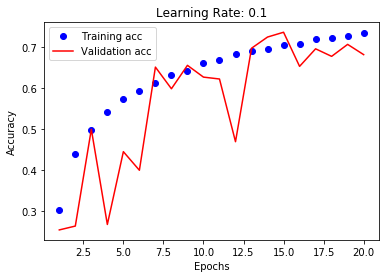

In [0]:
#Import matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

#Build new model and summarize
learning_rates = [0.0001, 0.001, 0.01, 0.1]

for learning_rate in learning_rates:
  print('Learning Rate: {0:f}'.format(learning_rate))
  #Create new model
  cnn = build_model()
  
  #Compile with current learning rate
  cnn.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])
  
  #Fit model using current learning rate
  history = cnn.fit_generator(training_generator,
                              steps_per_epoch = 800, 
                              epochs = 20, 
                              validation_data = validation_generator,
                              validation_steps = 200)
  
  #Plot training and validation accuracy
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  epochs = range(1,len(acc)+1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Learning Rate: '+str(learning_rate))
  plt.legend()
  plt.show()  

In [0]:
#Run best learning rate for additional epochs
learning_rate = 0.001

#Create new model
cnn = build_model()
  
#Compile with current learning rate
cnn.compile(loss='categorical_crossentropy',
            optimizer=optimizers.RMSprop(lr=learning_rate),
            metrics=['acc'])
  
#Fit model using current learning rate
history = cnn.fit_generator(training_generator,
                            steps_per_epoch = 800, 
                            epochs = 50, 
                            validation_data = validation_generator,
                            validation_steps = 200)

Epoch 1/50
800/800 [==============================] - 424s 530ms/step - loss: 1.6495 - acc: 0.4036 - val_loss: 1.4181 - val_acc: 0.5192
Epoch 2/50
800/800 [==============================] - 403s 503ms/step - loss: 1.2770 - acc: 0.5574 - val_loss: 1.1790 - val_acc: 0.6014
Epoch 3/50
800/800 [==============================] - 402s 503ms/step - loss: 1.0909 - acc: 0.6247 - val_loss: 1.2608 - val_acc: 0.5968
Epoch 4/50
800/800 [==============================] - 403s 503ms/step - loss: 0.9774 - acc: 0.6672 - val_loss: 1.0063 - val_acc: 0.6720
Epoch 5/50
800/800 [==============================] - 401s 501ms/step - loss: 0.8908 - acc: 0.6979 - val_loss: 0.9519 - val_acc: 0.6994
Epoch 6/50
800/800 [==============================] - 402s 503ms/step - loss: 0.8219 - acc: 0.7240 - val_loss: 0.8910 - val_acc: 0.7082
Epoch 7/50
800/800 [==============================] - 403s 504ms/step - loss: 0.7666 - acc: 0.7413 - val_loss: 1.0493 - val_acc: 0.6710
Epoch 8/50
800/800 [============================

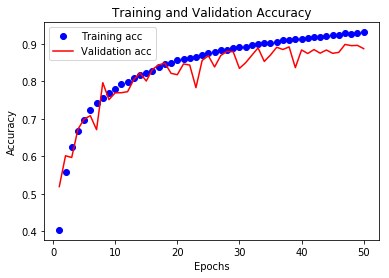

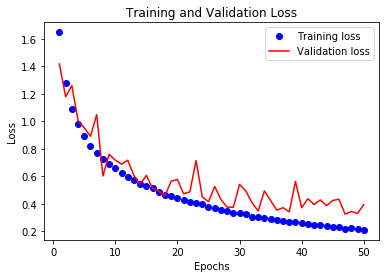

In [0]:
#Plot training and validation accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#Plot training and validation loss
acc = history.history['loss']
val_acc = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training loss')
plt.plot(epochs, val_acc, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show() 

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [0]:
#Build and compile a final version of the model using the best learning rate
learning_rate=0.001

final_model = build_model()
final_model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.RMSprop(lr=learning_rate),
                    metrics=['acc'])

In [7]:
#Train final model using full training dataset
final_model.fit_generator(training_datagen.flow(x_train, y_train_vec, batch_size=50),
                          steps_per_epoch=1000,
                          epochs=30)

Epoch 1/30
1000/1000 [==============================] - 489s 489ms/step - loss: 1.5865 - acc: 0.4334
Epoch 2/30
1000/1000 [==============================] - 470s 470ms/step - loss: 1.2113 - acc: 0.5824
Epoch 3/30
1000/1000 [==============================] - 469s 469ms/step - loss: 1.0242 - acc: 0.6499
Epoch 4/30
1000/1000 [==============================] - 469s 469ms/step - loss: 0.9057 - acc: 0.6946
Epoch 5/30
1000/1000 [==============================] - 471s 471ms/step - loss: 0.8194 - acc: 0.7222
Epoch 6/30
1000/1000 [==============================] - 471s 471ms/step - loss: 0.7569 - acc: 0.7446
Epoch 7/30
1000/1000 [==============================] - 471s 471ms/step - loss: 0.7105 - acc: 0.7612
Epoch 8/30
1000/1000 [==============================] - 471s 471ms/step - loss: 0.6612 - acc: 0.7785
Epoch 9/30
1000/1000 [==============================] - 472s 472ms/step - loss: 0.6290 - acc: 0.7881
Epoch 10/30
1000/1000 [==============================] - 472s 472ms/step - loss: 0.5948 - a

### 3.2. Evaluate the model on the test set

Do NOT use the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [8]:
loss_and_acc = final_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

10000/10000 [==============================] - 26s 3ms/sample - loss: 0.4778 - acc: 0.8563
loss = 0.47781557049751283
accuracy = 0.8563
